In [10]:
import os, json, random, math, glob, hashlib
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont

import pprint
pp = pprint.PrettyPrinter(indent=2, width=120)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_seq_items', None)

# Questions Analysis

In [11]:
ROOT = Path("../clevr")
IMAGES = ROOT/"images"
QUESTIONS = ROOT/"questions"
SCENES = ROOT/"scenes"

SAMPLE_SIZE = 5000

splits = ["train", "val", "test"]
for s in splits:
    print(s, "images:", len(list((IMAGES/s).glob("*.png"))))

print("questions json:", len(list((QUESTIONS).glob("CLEVR_*_questions.json"))))
print("scenes json:", len(list((SCENES).glob("CLEVR_*_scenes.json"))))


train images: 70000
val images: 15000
test images: 15000
questions json: 3
scenes json: 2


In [12]:
def load_questions_json(path, limit=None):
    with open(path, "r") as file:
        data = json.load(file)
    
    questions = data["questions"]
    questions = questions[:limit]
    return questions

q_train = load_questions_json(QUESTIONS/"CLEVR_train_questions.json", limit=SAMPLE_SIZE)
q_val   = load_questions_json(QUESTIONS/"CLEVR_val_questions.json", limit=SAMPLE_SIZE//5)

df_question = pd.DataFrame(q_train + q_val)

In [17]:

sample_idx = random.randint(0, len(df_question) - 1)
sample = df_question.iloc[sample_idx].to_dict()

print(f"QUESTION EXAMLPE #{sample_idx} - complete JSON")
print()

print(f"Image: {sample['image_filename']}")
print(f"Question: {sample['question']}")
print(f"Answer: {sample['answer']}")
print(f"Split: {sample['split']}")
print(f"Family: {sample['question_family_index']}")
print()

print("FUNCTIONAL PROGRAM (DSL):")
print()

for i, step in enumerate(sample['program']):
    print(f"({i}) {step['function']}")
    if 'inputs' in step and step['inputs']:
        print(f"    -inputs:       {step['inputs']}")
    if 'value_inputs' in step and step['value_inputs']:
        print(f"    -value_inputs: {step['value_inputs']}")
    if 'side_inputs' in step and step['side_inputs']:
        print(f"    -side_inputs:  {step['side_inputs']}")
    print()

print("RAW JSON:")

print(json.dumps(sample, indent=2, ensure_ascii=False))

QUESTION EXAMLPE #2741 - complete JSON

Image: CLEVR_train_000274.png
Question: Is there anything else that has the same size as the cyan metal cube?
Answer: no
Split: train
Family: 36

FUNCTIONAL PROGRAM (DSL):

(0) scene

(1) filter_color
    -inputs:       [0]
    -value_inputs: ['cyan']

(2) filter_material
    -inputs:       [1]
    -value_inputs: ['metal']

(3) filter_shape
    -inputs:       [2]
    -value_inputs: ['cube']

(4) unique
    -inputs:       [3]

(5) same_size
    -inputs:       [4]

(6) exist
    -inputs:       [5]

RAW JSON:
{
  "image_index": 274,
  "program": [
    {
      "inputs": [],
      "function": "scene",
      "value_inputs": []
    },
    {
      "inputs": [
        0
      ],
      "function": "filter_color",
      "value_inputs": [
        "cyan"
      ]
    },
    {
      "inputs": [
        1
      ],
      "function": "filter_material",
      "value_inputs": [
        "metal"
      ]
    },
    {
      "inputs": [
        2
      ],
      "function

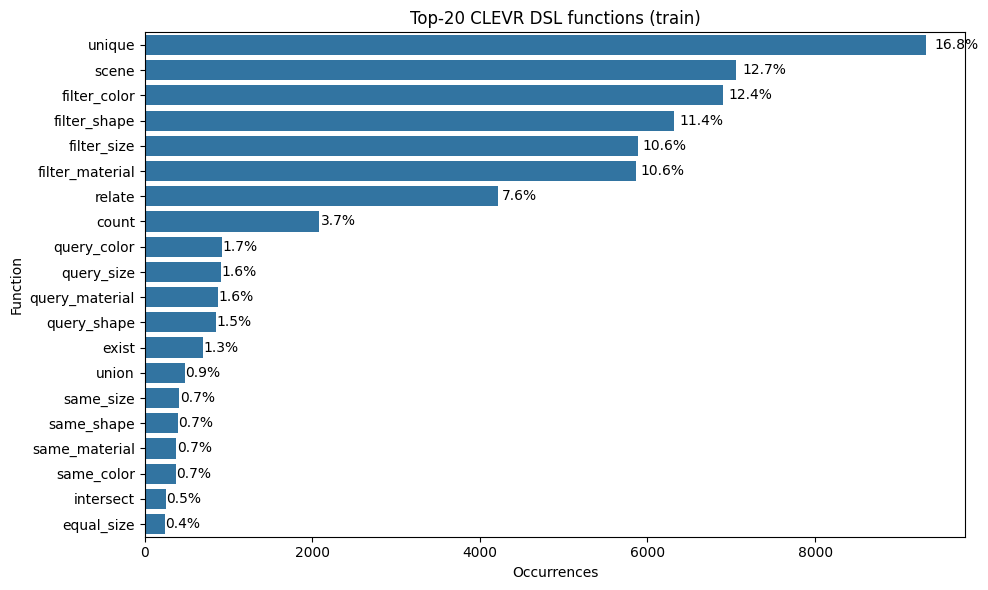

In [18]:
all_functions = []
program_lengths = []
for q in q_train:
    program = q["program"]
    program_lengths.append(len(program))
    for p in program:
        all_functions.append(p["function"])

function_cnt= Counter(all_functions)
total_funcs = len(all_functions)

topN = 20
top_items = function_cnt.most_common(topN)
df_funcs = pd.DataFrame(top_items, columns=["function", "count"])
df_funcs["pct"] = 100 * df_funcs["count"] / total_funcs

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_funcs.sort_values("count", ascending=False),
    x="count", y="function", orient="h"
)
ax.set_title("Top-20 CLEVR DSL functions (train)")
ax.set_xlabel("Occurrences")
ax.set_ylabel("Function")

for i, (_, row) in enumerate(df_funcs.sort_values("count", ascending=False).iterrows()):
    ax.text(row["count"] * 1.01, i, f"{row['pct']:.1f}%", va="center")

plt.tight_layout()
plt.show()



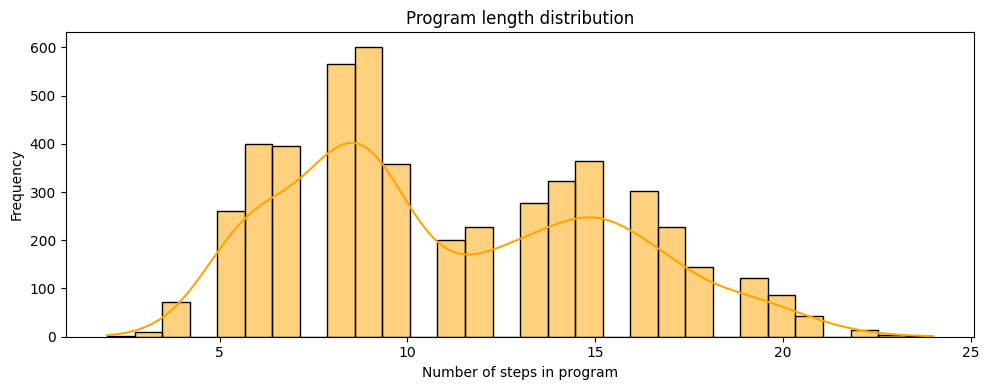

In [19]:
df_len = pd.DataFrame({"prog_len": program_lengths})

plt.figure(figsize=(10, 4))
ax = sns.histplot(df_len["prog_len"], bins=30, kde=True, color="orange")
ax.set_title("Program length distribution")
ax.set_xlabel("Number of steps in program")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


Families: 90


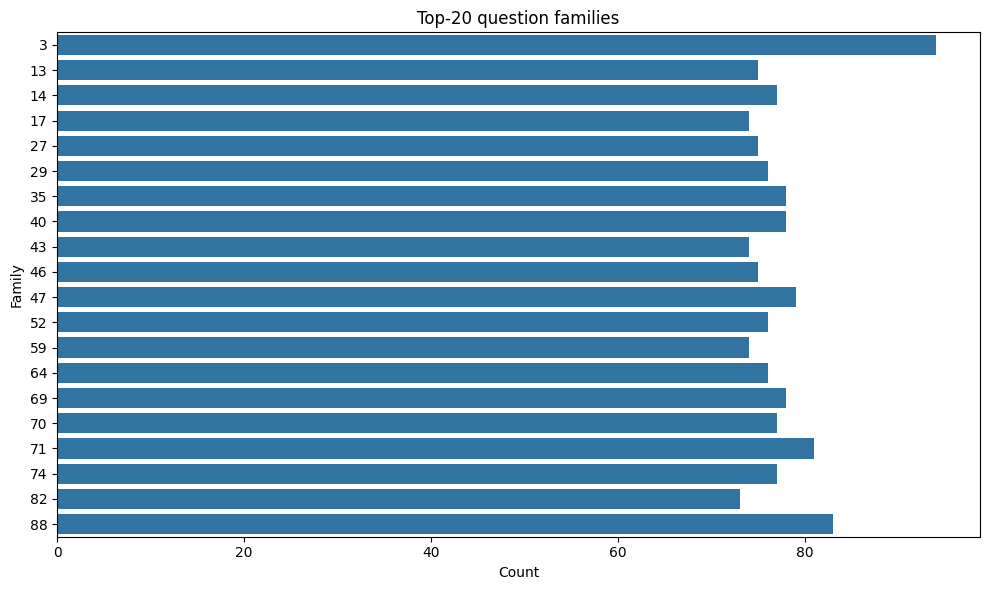

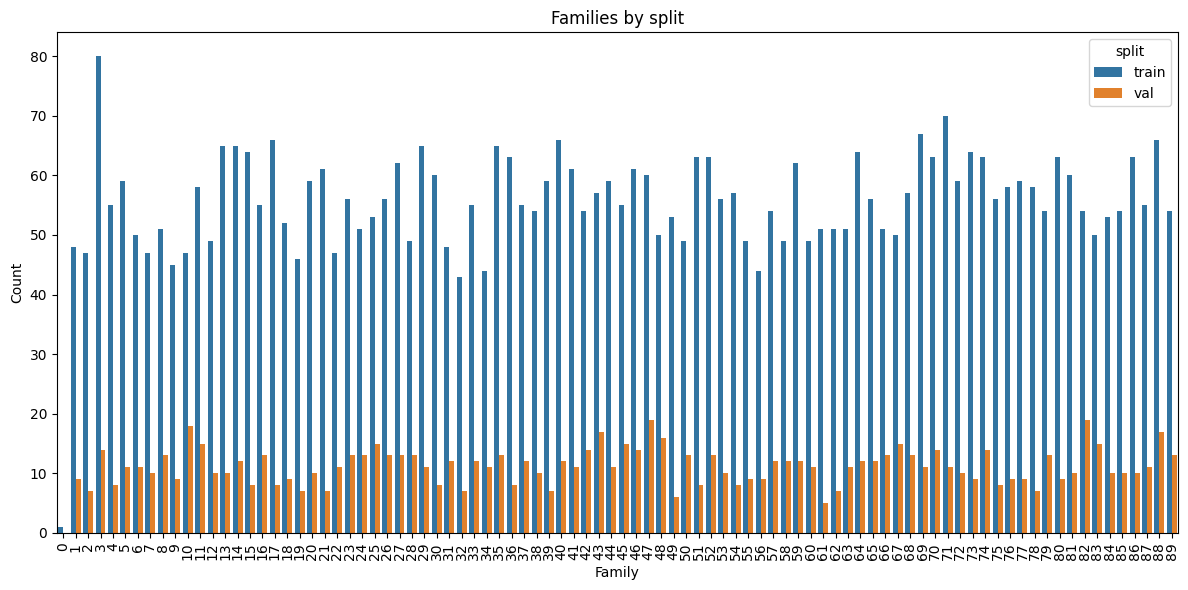

In [20]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

if 'question_family_index' in df_question.columns:
    fam_counts = df_question['question_family_index'].value_counts().rename_axis('family').reset_index(name='count')
    print("Families:", df_question['question_family_index'].nunique())

    
    topF = fam_counts.head(20)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=topF, y='family', x='count', orient='h')
    ax.set_title("Top-20 question families")
    ax.set_xlabel("Count");
    ax.set_ylabel("Family")
    plt.tight_layout(); plt.show()

    
    fam_split = df_question.groupby(['split','question_family_index']).size().reset_index(name='count')
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=fam_split, x='question_family_index', y='count', hue='split')
    ax.set_title("Families by split")
    ax.set_xlabel("Family"); 
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout(); 
    plt.show()

## Scene Analysis

In [21]:
def load_scenes_json(path, limit=None):
    with open(path, "r") as file:
        data = json.load(file)
    
    scenes = data["scenes"]
    scenes = scenes[:limit]
    return scenes

s_train = load_scenes_json(SCENES/"CLEVR_train_scenes.json", limit=SAMPLE_SIZE)
s_val = load_scenes_json(SCENES/"CLEVR_val_scenes.json", limit=SAMPLE_SIZE//5)

df_scenes = pd.DataFrame(s_train + s_val)
print(f"Loaded {len(df_scenes)} scenes")


Loaded 6000 scenes


In [40]:
all_objects = []
num_objects_per_scene = []

for scene in s_train:
    objects = scene['objects']
    num_objects_per_scene.append(len(objects))
    all_objects.extend(objects)

print(f"Total objects: {len(all_objects)}")
print(f"Avg objects per scene: {np.mean(num_objects_per_scene):.2f}")
print(f"Min objects: {np.min(num_objects_per_scene)}")
print(f"Max objects: {np.max(num_objects_per_scene)}")
print()

colors = [obj['color'] for obj in all_objects]
shapes = [obj['shape'] for obj in all_objects]
sizes = [obj['size'] for obj in all_objects]
materials = [obj['material'] for obj in all_objects]

print("Attribute distributions:")
print(f"    Colors ({len(set(colors))} unique): {Counter(colors)}")
print(f"    Shapes ({len(set(shapes))} unique): {Counter(shapes)}")
print(f"    Sizes ({len(set(sizes))} unique): {Counter(sizes)}")
print(f"    Materials ({len(set(materials))} unique): {Counter(materials)}")
print()

Total objects: 32491
Avg objects per scene: 6.50
Min objects: 3
Max objects: 10

Attribute distributions:
    Colors (8 unique): Counter({'blue': 4157, 'yellow': 4149, 'gray': 4113, 'brown': 4053, 'green': 4048, 'cyan': 4014, 'purple': 4011, 'red': 3946})
    Shapes (3 unique): Counter({'sphere': 10904, 'cube': 10882, 'cylinder': 10705})
    Sizes (2 unique): Counter({'small': 17092, 'large': 15399})
    Materials (2 unique): Counter({'rubber': 16332, 'metal': 16159})



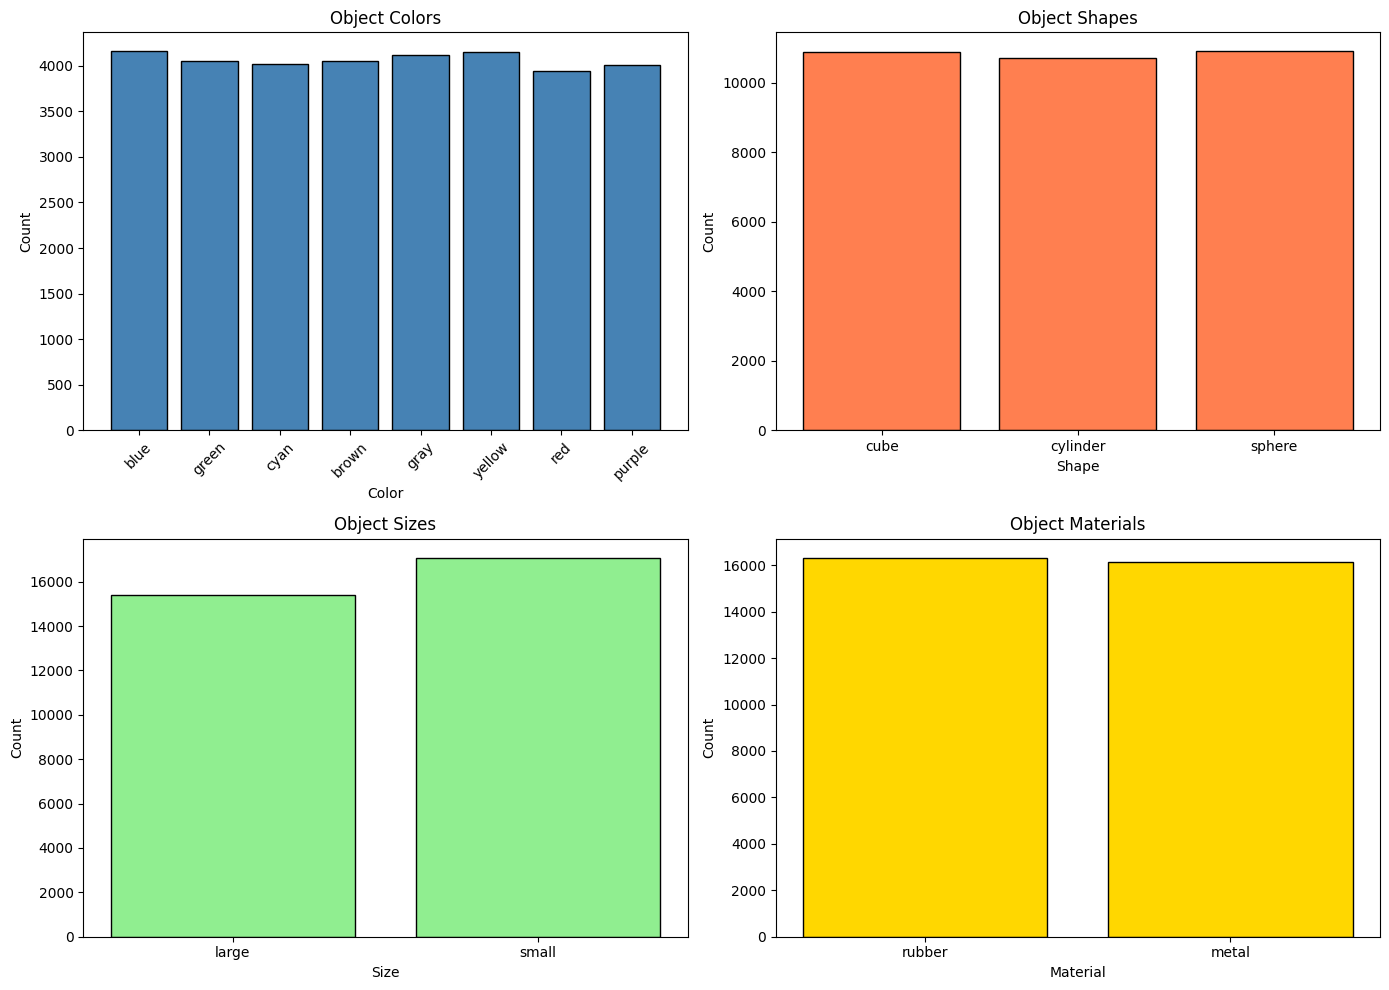

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

color_counts = Counter(colors)
axes[0, 0].bar(color_counts.keys(), color_counts.values(), color='steelblue', edgecolor='black')
axes[0, 0].set_title("Object Colors")
axes[0, 0].set_xlabel("Color")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis='x', rotation=45)

shape_counts = Counter(shapes)
axes[0, 1].bar(shape_counts.keys(), shape_counts.values(), color='coral', edgecolor='black')
axes[0, 1].set_title("Object Shapes")
axes[0, 1].set_xlabel("Shape")
axes[0, 1].set_ylabel("Count")

size_counts = Counter(sizes)
axes[1, 0].bar(size_counts.keys(), size_counts.values(), color='lightgreen', edgecolor='black')
axes[1, 0].set_title("Object Sizes")
axes[1, 0].set_xlabel("Size")
axes[1, 0].set_ylabel("Count")

material_counts = Counter(materials)
axes[1, 1].bar(material_counts.keys(), material_counts.values(), color='gold', edgecolor='black')
axes[1, 1].set_title("Object Materials")
axes[1, 1].set_xlabel("Material")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

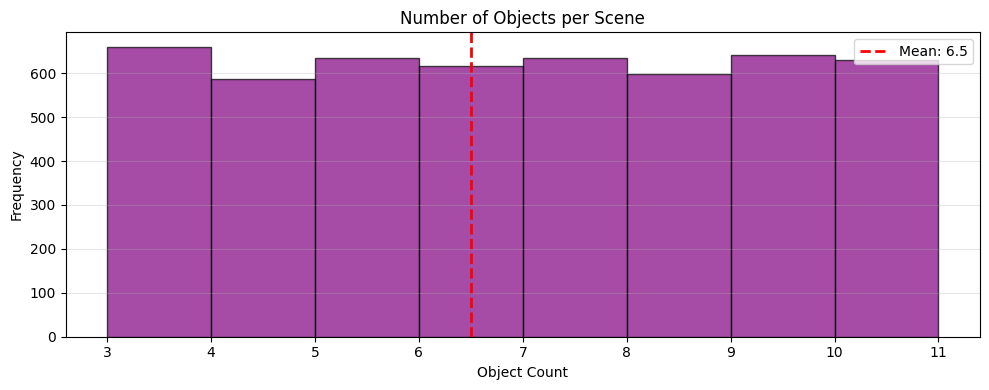

In [24]:
plt.figure(figsize=(10, 4))
plt.hist(num_objects_per_scene, bins=range(min(num_objects_per_scene), max(num_objects_per_scene)+2), 
         color='purple', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(num_objects_per_scene), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(num_objects_per_scene):.1f}')
plt.title("Number of Objects per Scene")
plt.xlabel("Object Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Image Visualization with Scene Graph and Questions

## Detailed Image Analysis

In [38]:
def detailed_scene_analysis(image_filename, scenes, questions):
    scene = next((s for s in scenes if s['image_filename'] == image_filename), None)
    if not scene:
        print(f"Scene not found: {image_filename}")
        return None
    
    img_questions = [q for q in questions if q['image_filename'] == image_filename]
    
    print(f"COMPLETE SCENE ANALYSIS: {image_filename}")
    print()
    
    print(f"Split: {scene['split']}")
    print(f"Image index: {scene['image_index']}")
    print(f"Objects: {len(scene['objects'])}")
    print(f"Questions available: {len(img_questions)}")
    print()
    
    print("OBJECTS IN SCENE:")
    for i, obj in enumerate(scene['objects']):
        print(f"\n[Object {i}]")
        print(f"  Size: {obj['size']}")
        print(f"  Color: {obj['color']}")
        print(f"  Material: {obj['material']}")
        print(f"  Shape: {obj['shape']}")
        print(f"  3D coords: ({obj['3d_coords'][0]:.2f}, {obj['3d_coords'][1]:.2f}, {obj['3d_coords'][2]:.2f})")
        print(f"  Rotation: {obj['rotation']:.2f}")
        print(f"  Pixel: {obj['pixel_coords']}")
    
    print()
    print("SPATIAL RELATIONSHIPS:")
    relationships = scene['relationships']
    
    for rel_type in ['left', 'right', 'front', 'behind']:
        print(f"\n{rel_type.upper()}:")
        has_relations = False
        for obj_idx, related_indices in enumerate(relationships[rel_type]):
            if related_indices:
                has_relations = True
                obj_desc = f"{scene['objects'][obj_idx]['color']} {scene['objects'][obj_idx]['shape']}"
                related_descs = [f"{scene['objects'][ri]['color']} {scene['objects'][ri]['shape']}" 
                                for ri in related_indices]
                print(f"  [{obj_idx}] {obj_desc} is {rel_type} of:")
                for ri, desc in zip(related_indices, related_descs):
                    print(f"      [{ri}] {desc}")
        
        if not has_relations:
            print(f"  (no {rel_type} relationships)")
    
    print()
    print(f"QUESTIONS FOR THIS IMAGE ({len(img_questions)} total):")
    print()
    
    for i, q in enumerate(img_questions, 1):
        print(f"\n[Question {i}]")
        print(f"    Q: {q['question']}")
        print(f"    A: {q['answer']}")
        print(f"    Family: {q['question_family_index']}")
        print(f"    Program ({len(q['program'])} steps):")
        for j, step in enumerate(q['program']):
            inputs_str = f"inputs={step.get('inputs', [])}" if step.get('inputs') else ""
            value_str = f"values={step.get('value_inputs', [])}" if step.get('value_inputs') else ""
            side_str = f"side={step.get('side_inputs', [])}" if step.get('side_inputs') else ""
            args = ", ".join([s for s in [inputs_str, value_str, side_str] if s])
            print(f"    [{j}] {step['function']}({args})")
    
    return scene, img_questions

In [39]:
images_with_questions = set([q['image_filename'] for q in q_train + q_val])
available_scenes = [s for s in s_train if s['image_filename'] in images_with_questions]

scene_question_counts = Counter([q['image_filename'] for q in q_train + q_val])
rich_images = [img for img, count in scene_question_counts.most_common(50) if count >= 10]

if rich_images:
    example_image = random.choice(rich_images)
    print(f"Analyzing image with many questions: {example_image}")
    print()
    scene_data, questions_data = detailed_scene_analysis(
        example_image,
        s_train + s_val,
        q_train + q_val
    )
else:
    print("No images with many questions found in sample")

Analyzing image with many questions: CLEVR_train_000021.png

COMPLETE SCENE ANALYSIS: CLEVR_train_000021.png

Split: train
Image index: 21
Objects: 3
Questions available: 10

OBJECTS IN SCENE:

[Object 0]
  Size: small
  Color: blue
  Material: metal
  Shape: sphere
  3D coords: (-1.46, -0.48, 0.35)
  Rotation: 176.90
  Pixel: [183, 131, 12.212920188903809]

[Object 1]
  Size: large
  Color: blue
  Material: rubber
  Shape: cube
  3D coords: (0.16, 0.44, 0.70)
  Rotation: 297.49
  Pixel: [260, 128, 11.501439094543457]

[Object 2]
  Size: small
  Color: green
  Material: metal
  Shape: cube
  3D coords: (-1.04, -2.22, 0.35)
  Rotation: 258.80
  Pixel: [127, 160, 10.922049522399902]

SPATIAL RELATIONSHIPS:

LEFT:
  [0] blue sphere is left of:
      [2] green cube
  [1] blue cube is left of:
      [0] blue sphere
      [2] green cube

RIGHT:
  [0] blue sphere is right of:
      [1] blue cube
  [2] green cube is right of:
      [0] blue sphere
      [1] blue cube

FRONT:
  [0] blue sphere 

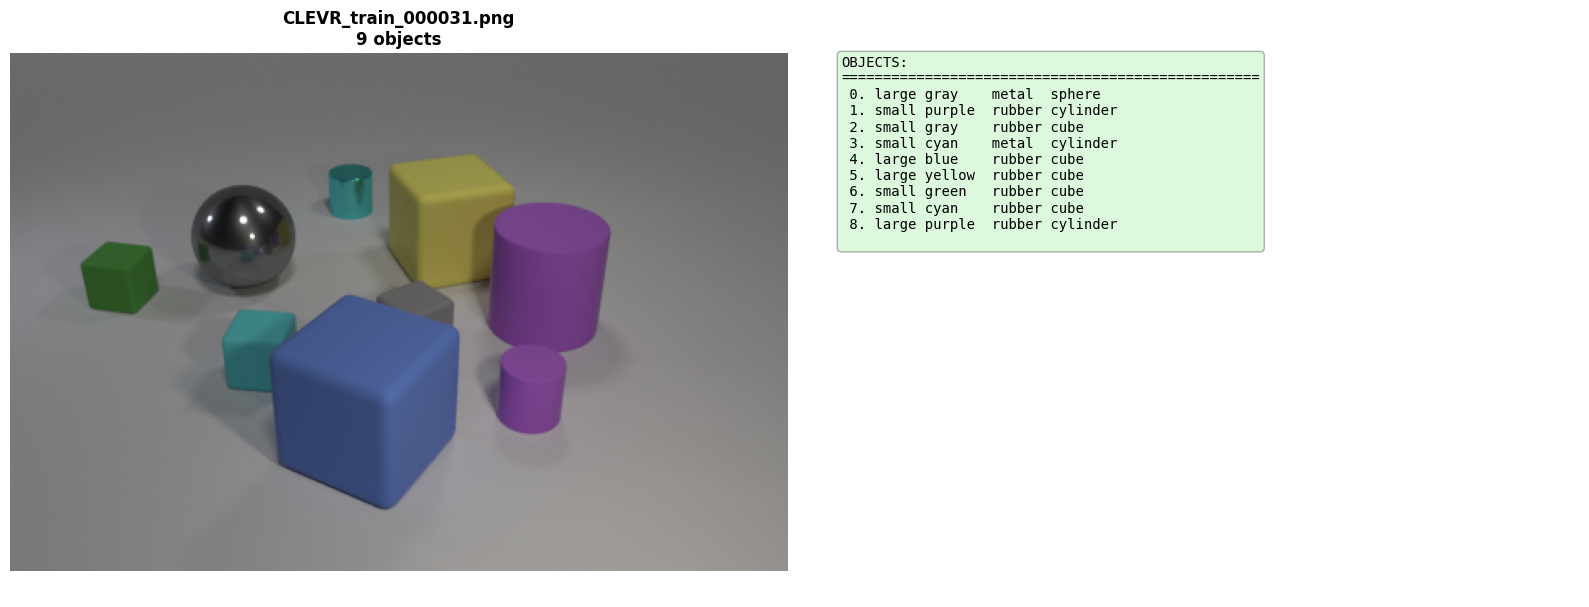

In [ ]:
if rich_images and scene_data:
    img_path = IMAGES / scene_data['split'] / scene_data['image_filename']
    if img_path.exists():
        img = Image.open(img_path)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        axes[0].imshow(img)
        axes[0].axis('off')
        axes[0].set_title(f"{scene_data['image_filename']}\n{len(scene_data['objects'])} objects", 
                         fontsize=12, fontweight='bold')
        
        axes[1].axis('off')
        
        summary_text = "OBJECTS:\n"
        summary_text += "=" * 50 + "\n"
        for i, obj in enumerate(scene_data['objects']):
            summary_text += f"{i:2d}. {obj['size']:5s} {obj['color']:7s} {obj['material']:6s} {obj['shape']}\n"
        
        axes[1].text(0.05, 0.95, summary_text, transform=axes[1].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
        
        plt.tight_layout()
        plt.show()

In [27]:
def visualize_scene_with_questions(image_filename, scenes, questions, max_questions=5):
    scene = next((s for s in scenes if s['image_filename'] == image_filename), None)
    if not scene:
        print(f"Scene not found: {image_filename}")
        return
    
    img_questions = [q for q in questions if q['image_filename'] == image_filename]
    img_questions = img_questions[:max_questions]
    
    img_path = IMAGES / scene['split'] / image_filename
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    img = Image.open(img_path)
    
    fig = plt.figure(figsize=(18, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 1.5, 1.5])
    
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"Image: {image_filename}", fontsize=12, fontweight='bold')
    
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')
    
    objects_text = f"SCENE GRAPH ({len(scene['objects'])} objects)\n"
    objects_text += "=" * 40 + "\n\n"
    
    for i, obj in enumerate(scene['objects'][:10]):
        objects_text += f"{i:2d}. {obj['size']:5s} {obj['color']:6s} {obj['material']:6s} {obj['shape']}\n"
        objects_text += f"    3D: ({obj['3d_coords'][0]:5.2f}, {obj['3d_coords'][1]:5.2f}, {obj['3d_coords'][2]:5.2f})\n"
    
    if len(scene['objects']) > 10:
        objects_text += f"\n... +{len(scene['objects']) - 10} more objects\n"
    
    ax2.text(0.05, 0.95, objects_text, transform=ax2.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    
    questions_text = f"QUESTIONS ({len(img_questions)})\n"
    questions_text += "=" * 40 + "\n\n"
    
    for i, q in enumerate(img_questions, 1):
        questions_text += f"Q{i}: {q['question']}\n"
        questions_text += f"A{i}: {q['answer']}\n\n"
        
        program_funcs = [step['function'] for step in q['program']]
        program_str = ' -> '.join(program_funcs[:4])
        if len(program_funcs) > 4:
            program_str += " -> ..."
        questions_text += f"    {program_str}\n\n"
    
    ax3.text(0.05, 0.95, questions_text, transform=ax3.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    return scene, img_questions

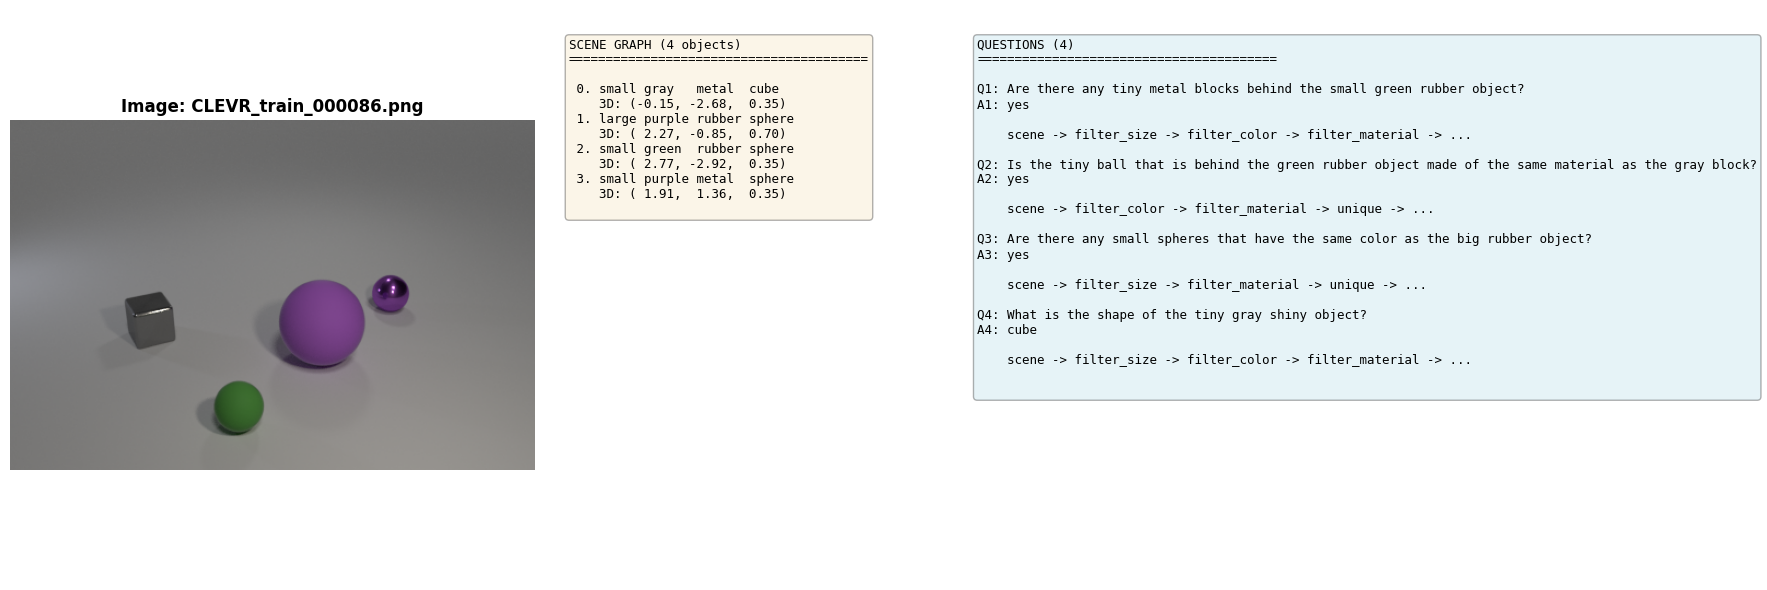

Example 1: CLEVR_train_000086.png - 4 questions found



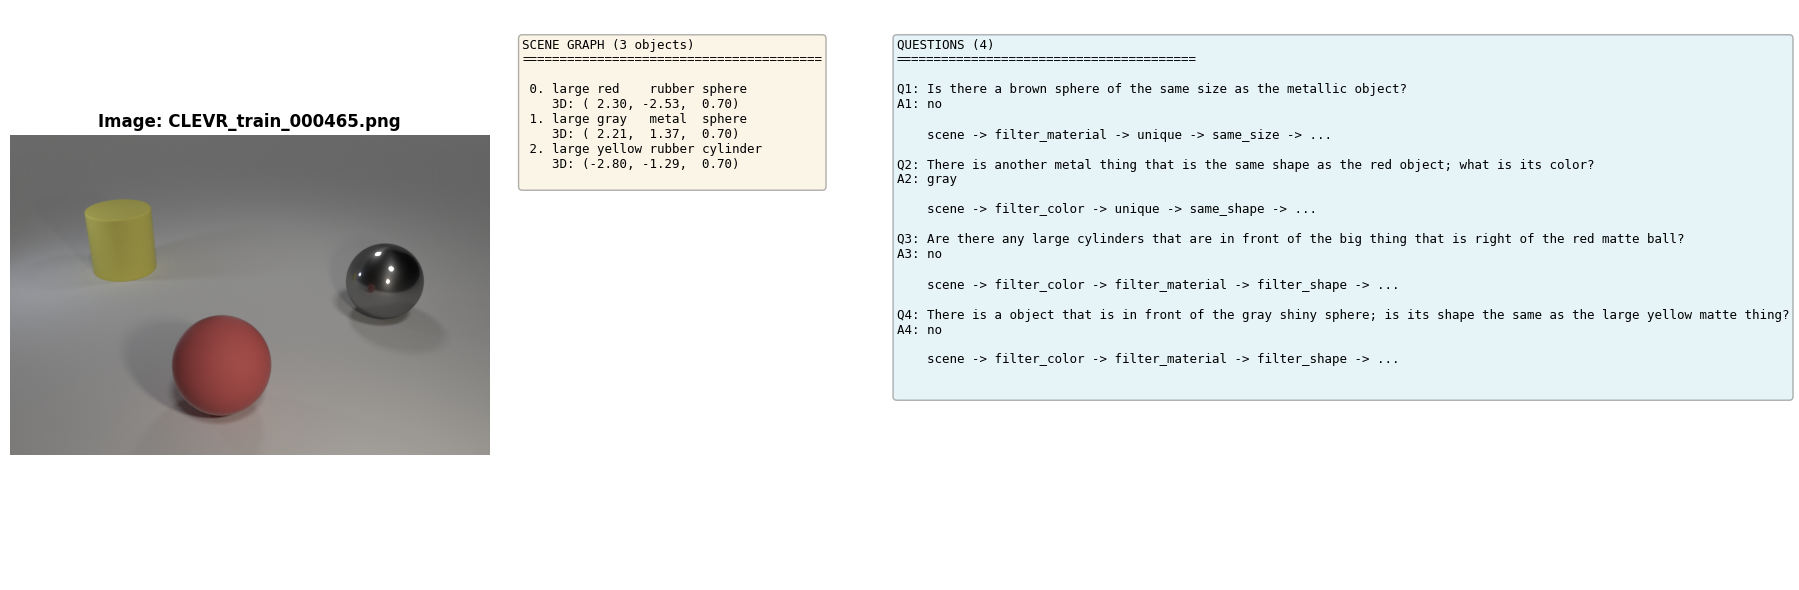

Example 2: CLEVR_train_000465.png - 4 questions found



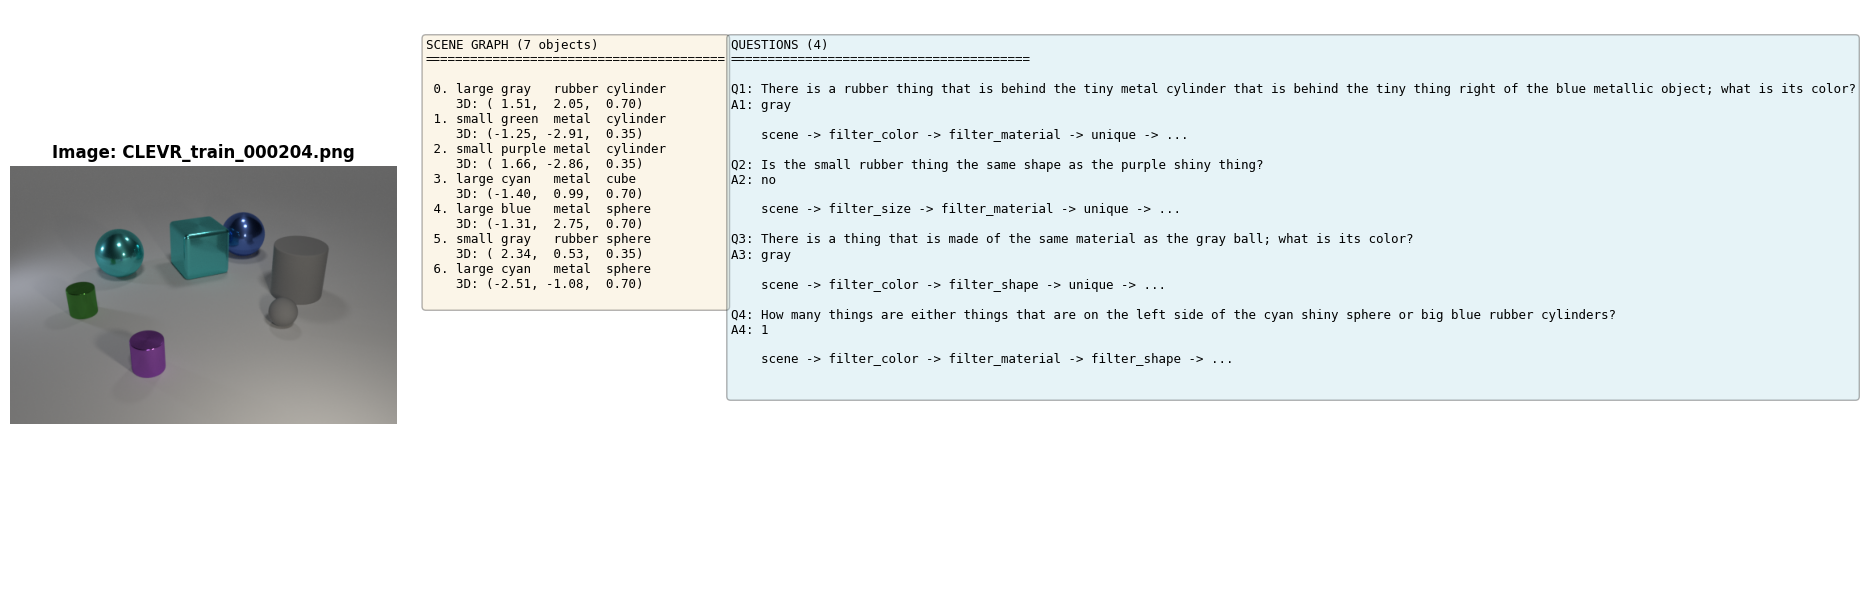

Example 3: CLEVR_train_000204.png - 4 questions found



In [ ]:
print()

images_with_questions = set([q['image_filename'] for q in q_train + q_val])
available_scenes = [s for s in s_train if s['image_filename'] in images_with_questions]

print()

for i in range(3):
    random_scene = random.choice(available_scenes)
    scene_data, questions_data = visualize_scene_with_questions(
        random_scene['image_filename'],
        s_train + s_val,
        q_train + q_val,
        max_questions=4
    )
    if questions_data:
        print(f"Example {i+1}: {random_scene['image_filename']} - {len(questions_data)} questions found")
    else:
        print(f"Example {i+1}: {random_scene['image_filename']} - No questions (should not happen)")
    print()

## Scene Graph Relationships Analysis

Spatial Relationships Statistics:
Total objects: 32491
Total relationship instances: 410420

Relationship type distribution:
  left: 102605 (25.0%)
  right: 102605 (25.0%)
  front: 102605 (25.0%)
  behind: 102605 (25.0%)



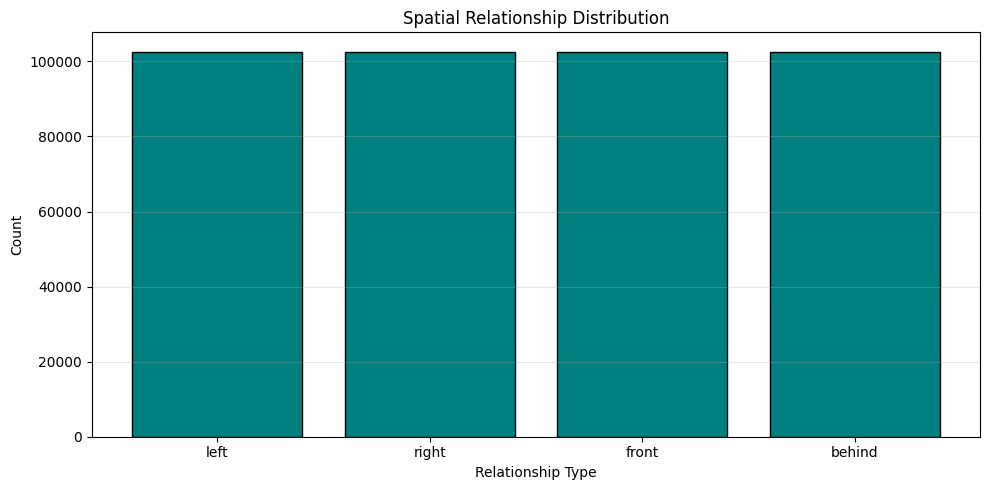

In [37]:
relation_types = ['left', 'right', 'front', 'behind']
relation_counts = {rel: 0 for rel in relation_types}

for scene in s_train:
    relationships = scene['relationships']
    for rel_type in relation_types:
        if rel_type in relationships:
            for obj_idx, related_indices in enumerate(relationships[rel_type]):
                relation_counts[rel_type] += len(related_indices)

total_relations = sum(relation_counts.values())

print("Spatial Relationships Statistics:")
print(f"Total objects: {sum(num_objects_per_scene)}")
print(f"Total relationship instances: {total_relations}")
print()

print("Relationship type distribution:")
for rel_type, count in relation_counts.items():
    pct = (count / total_relations) * 100 if total_relations > 0 else 0
    print(f"  {rel_type}: {count} ({pct}%)")

print()

plt.figure(figsize=(10, 5))
plt.bar(relation_counts.keys(), relation_counts.values(), color='teal', edgecolor='black')
plt.title("Spatial Relationship Distribution")
plt.xlabel("Relationship Type")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
example_scene = random.choice(s_train)

print("DETAILED SCENE GRAPH EXAMPLE")
print()
print(f"Image: {example_scene['image_filename']}")
print(f"Split: {example_scene['split']}")
print(f"Objects: {len(example_scene['objects'])}")
print()

print("OBJECTS:")
print()
for i, obj in enumerate(example_scene['objects']):
    print(f"[{i}] {obj['size']} {obj['color']} {obj['material']} {obj['shape']}")
    print(f"    Position (3D): ({obj['3d_coords'][0]:.2f}, {obj['3d_coords'][1]:.2f}, {obj['3d_coords'][2]:.2f})")
    print(f"    Pixel coords: {obj['pixel_coords']}")
    print()

print("RELATIONSHIPS:")
print()
relationships = example_scene['relationships']
for rel_type in ['left', 'right', 'front', 'behind']:
    print(f"\n{rel_type.upper()}:")
    for obj_idx, related_indices in enumerate(relationships[rel_type]):
        if related_indices:
            print(f"  Object {obj_idx} is {rel_type} of: {related_indices}")

DETAILED SCENE GRAPH EXAMPLE

Image: CLEVR_train_000108.png
Split: train
Objects: 7

OBJECTS:

[0] small brown metal cube
    Position (3D): (-2.55, -2.57, 0.35)
    Pixel coords: [71, 137, 11.194281578063965]

[1] small gray rubber sphere
    Position (3D): (1.03, -2.09, 0.35)
    Pixel coords: [183, 203, 9.034110069274902]

[2] small blue rubber cube
    Position (3D): (-1.50, 2.11, 0.35)
    Pixel coords: [268, 98, 13.049078941345215]

[3] large yellow rubber cube
    Position (3D): (-2.81, 2.36, 0.70)
    Pixel coords: [243, 69, 13.902022361755371]

[4] large brown rubber cylinder
    Position (3D): (0.39, 1.67, 0.70)
    Pixel coords: [311, 115, 11.358515739440918]

[5] large red rubber cube
    Position (3D): (-1.32, -2.16, 0.70)
    Pixel coords: [114, 138, 10.410982131958008]

[6] large brown metal cube
    Position (3D): (2.48, 0.54, 0.70)
    Pixel coords: [352, 170, 9.323188781738281]

RELATIONSHIPS:


LEFT:
  Object 1 is left of: [0, 5]
  Object 2 is left of: [0, 1, 3, 5]
 

## Summary Statistics

In [35]:
summary = {
    "Questions": {
        "Total samples": len(df_question),
        "Train": len([q for q in q_train]),
        "Val": len([q for q in q_val]),
        "Unique families": df_question['question_family_index'].nunique(),
        "Avg question length (words)": np.mean([len(q['question'].split()) for q in q_train]),
        "Avg program length": np.mean(program_lengths),
    },
    "Scenes": {
        "Total scenes": len(df_scenes),
        "Total objects": len(all_objects),
        "Avg objects per scene": np.mean(num_objects_per_scene),
        "Min objects": np.min(num_objects_per_scene),
        "Max objects": np.max(num_objects_per_scene),
        "Unique colors": len(set(colors)),
        "Unique shapes": len(set(shapes)),
        "Unique sizes": len(set(sizes)),
        "Unique materials": len(set(materials)),
    },
    "DSL Functions": {
        "Total function calls": len(all_functions),
        "Unique functions": len(function_cnt),
        "Most common": function_cnt.most_common(1)[0][0],
    },
    "Relationships": {
        "Total relations": sum(relation_counts.values()),
        "Left": relation_counts['left'],
        "Right": relation_counts['right'],
        "Front": relation_counts['front'],
        "Behind": relation_counts['behind'],
    }
}

print()
print("CLEVR DATASET SUMMARY (Sample)")
print()

for category, stats in summary.items():
    print(f"{category}:")
    for key, value in stats.items():
        print(f"    {key}: {value}")
    print()


CLEVR DATASET SUMMARY (Sample)

Questions:
    Total samples: 6000
    Train: 5000
    Val: 1000
    Unique families: 90
    Avg question length (words): 18.3274
    Avg program length: 11.0994

Scenes:
    Total scenes: 6000
    Total objects: 32491
    Avg objects per scene: 6.4982
    Min objects: 3
    Max objects: 10
    Unique colors: 8
    Unique shapes: 3
    Unique sizes: 2
    Unique materials: 2

DSL Functions:
    Total function calls: 55497
    Unique functions: 26
    Most common: unique

Relationships:
    Total relations: 410420
    Left: 102605
    Right: 102605
    Front: 102605
    Behind: 102605

